In [86]:
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import NMF
from sklearn.neighbors import NearestNeighbors

In [6]:
base = "./transactions_data/"

order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
# orders_df = pd.read_csv(base + "orders.csv")
products_df = pd.read_csv("products.csv")
# aisles_df = pd.read_csv(base + "aisles.csv")
# departments_df = pd.read_csv(base + "departments.csv")

In [7]:
order_products_train_df = order_products_train_df[["order_id", "product_id"]]
order_products_train_df.head()

,order_id,product_id
0,1,49302
1,1,11109
2,1,10246
3,1,49683
4,1,43633


In [8]:
order_products_prior_df = order_products_prior_df[["order_id", "product_id"]]
order_products_prior_df.head()

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


In [9]:
order_products_df = pd.concat([order_products_train_df, order_products_prior_df])
order_products_df = order_products_df[order_products_df["order_id"] <= 10000]
order_products_df.sort_values("order_id", inplace=True, ignore_index=True)
order_products_df

,order_id,product_id
0,1,49302
1,1,11109
2,1,10246
3,1,49683
4,1,43633
...,...,...
98486,10000,10017
98487,10000,10369
98488,10000,6587
98489,10000,35108


In [10]:
products_in_transactions = order_products_df.groupby("product_id").count().rename(columns={"order_id": "no_of_transactions"}).reset_index()
products_in_transactions.sort_values("no_of_transactions", ascending=False).reset_index(drop=True)

,product_id,no_of_transactions
0,24852,1462
1,13176,1174
2,21137,789
3,21903,717
4,47209,637
...,...,...
16250,28973,1
16251,28969,1
16252,13751,1
16253,28961,1


In [11]:
order_products_df = order_products_df.merge(products_df[['product_id', 'product_name']], on='product_id')
order_products_df.sort_values("order_id", inplace=True, ignore_index=True)

In [12]:
order_products_df.head()

,order_id,product_id,product_name
0,1,49302,Bulgarian Yogurt
1,1,47209,Organic Hass Avocado
2,1,22035,Organic Whole String Cheese
3,1,49683,Cucumber Kirby
4,1,13176,Bag of Organic Bananas


In [13]:
order_products_df = order_products_df.groupby("order_id")['product_name'].agg(lambda x: ', '.join(x)).reset_index()

In [14]:
order_products_df.head()

,order_id,product_name
0,1,"Bulgarian Yogurt, Organic Hass Avocado, Organi..."
1,2,"Organic Egg Whites, Michigan Organic Kale, Cla..."
2,3,"Organic Baby Spinach, Total 2% with Strawberry..."
3,4,"Plain Pre-Sliced Bagels, Kellogg's Nutri-Grain..."
4,5,"Artichokes, Dairy Milk Fruit & Nut Chocolate B..."


In [15]:
transactions = order_products_df['product_name'].str.split(', ')

In [16]:
transactions

0       [Bulgarian Yogurt, Organic Hass Avocado, Organ...
1       [Organic Egg Whites, Michigan Organic Kale, Cl...
2       [Organic Baby Spinach, Total 2% with Strawberr...
3       [Plain Pre-Sliced Bagels, Kellogg's Nutri-Grai...
4       [Artichokes, Dairy Milk Fruit & Nut Chocolate ...
                              ...                        
9808    [French Feta, EF California White Basmati Eco-...
9809    [Cheese Shredded Mozzarella Reduced Fat 2%, Re...
9810    [Banana, Cereal Honey Bears, Broccoli Crown, O...
9811    [Bread, Country Buttermilk, Natural String Che...
9812    [Organic Cucumber, Organic Genoa Salami, Guaca...
Name: product_name, Length: 9813, dtype: object

In [17]:
unique_items = set(item for transaction in transactions for item in transaction)

In [18]:
unique_items

{'No Sugar Added Muesli Cereal',
 'Simply Clean Fragrance Free Wipes',
 'Light & Fit Greek Crunch Coconut Chocolate Bliss',
 'Sour Cream & Onion Flavored Potato Crisps',
 'Activia Mixed Berry/Black Cherry Lowfat Yogurt',
 'Original String Cheese',
 'Clay Instant Luminous Facial Mask',
 'Steamed Lentils',
 'Yellow Grape Tomatoes',
 'Basic Toilet Paper Toilet Tissue',
 'Organic Chickpeas Ready To Eat',
 'Disney Princess Assorted Sizes Adhesive Bandages',
 'Zucchini & Green Bean',
 'Chocolate Soy Milk',
 'Nonfat Plain Greek Yogurt',
 'Molasses',
 'Organic Carrot Cake Sprouted Cookies',
 'Tuna Florentine Cat Food',
 'Strips',
 'Cranberry Orange Oat Bar',
 'Love Crunch Dark Chocolate And Peanut Butter Granola',
 'Cinnamon Raisin Oat Bar',
 'Creamy Swiss Garlic & Herb Spreadable Cheese Wedges',
 'Defense Sugar Free Vitamin C Drops',
 'Soft Family 100% Whole Wheat Bread',
 'Classic French Demi-Glace',
 '70% Dark Chocolate With Orange Bar',
 'Dairy Milk Fine Chocolate Candy Bar',
 'Gummi Candy

In [19]:
def get_support(itemset, transactions):
    count = transactions.apply(lambda transaction: itemset.issubset(transaction)).sum()
    return count / len(transactions)

def get_confidence(itemset, antecedent, transactions):
    support_antecedent = get_support(antecedent, transactions)
    confidence = itemset["support"] / support_antecedent
    return confidence, support_antecedent

In [20]:
min_support = 0.005
min_confidence = 0.005

In [17]:
# frequent_itemsets = []
# for item in unique_items:
#     support = get_support({item}, transactions)
#     if support >= min_support:
#         frequent_itemsets.append({"itemset": item, "support": support, "k": 1})

In [18]:
# unique_items = set()
# for item_set in frequent_itemsets:
#     for item in item_set:
#         unique_items.add(item)

In [18]:
k = 1
frequent_itemsets = []
while unique_items:
    for item_pair in combinations(unique_items, k):
        support = get_support(set(item_pair), transactions)
        if support >= min_support:
            frequent_itemsets.append({"itemset": item_pair, "support": support, "k": k})
    
    unique_items = set()
    for item_set in frequent_itemsets:
        if item_set["k"] == k:
            for item in item_set["itemset"]:
                unique_items.add(item)
    
    k += 1
    print("k -->", k, (unique_items))

k --> 2 {'Large Alfresco Eggs', 'Sparkling Lemon Water', 'Organic White Onions', 'Organic Grade A Free Range Large Brown Eggs', 'Organic Bunch Beets', 'Organic Baby Carrots', 'Organic Egg Whites', 'Organic Baby Broccoli', 'Small Hass Avocado', 'Guacamole', 'Organic Black Beans', 'Organic Large Grade AA Brown Eggs', 'Organic American Cheese Singles', 'Garlic', 'Sparkling Mineral Water', 'Soda', 'Lemon Hummus', 'Broccoli Crown', 'Organic Large Extra Fancy Fuji Apple', 'Organic Zucchini', 'Hass Avocados', 'Gala Apples', 'Green Beans', 'Vanilla Almond Breeze Almond Milk', 'Macaroni & Cheese', 'Organic Extra Firm Tofu', 'Organic Navel Orange', 'Salted Butter', 'Green Onions', 'Extra Virgin Olive Oil', 'Organic Broccoli Crowns', 'Organic Hass Avocado', 'Organic Yams', 'Sweet Onion', 'Organic Whole Milk', '2% Milkfat', '100% Raw Coconut Water', 'Organic Reduced Fat Milk', 'Organic Green Seedless Grapes', 'Total 2% with Strawberry Lowfat Greek Strained Yogurt', 'Orange Bell Pepper', 'Raspberri

In [19]:
df = pd.DataFrame(frequent_itemsets)
df

,itemset,support,k
0,"(Large Alfresco Eggs,)",0.013248,1
1,"(Organic Sour Cream,)",0.009070,1
2,"(Lightly Salted Baked Snap Pea Crisps,)",0.006216,1
3,"(Spring Water,)",0.018343,1
4,"(Peach Pear Flavored Sparkling Water,)",0.006114,1
...,...,...,...
346,"(Banana, Original Hummus)",0.006216,2
347,"(Banana, Strawberries)",0.013553,2
348,"(Banana, Organic Raspberries)",0.007847,2
349,"(Milk, Vitamin D, Organic)",0.005809,3


In [21]:
df[df["k"] == 3]

,itemset,support,k
349,"(Organic, Vitamin D, Milk)",0.005809,3
350,"(Sweet Baby Kale, Super Spinach! Baby Spinach,...",0.005095,3


In [20]:
def generate_association_rules(frequent_itemsets, min_confidence, transactions):
    rules = []
    for itemset in frequent_itemsets:
        for size in range(1, len(itemset["itemset"])):
            for subset in combinations(itemset["itemset"], size):
                antecedent = set(subset)
                consequent = set(itemset["itemset"]) - antecedent
                confidence, support_antecedent = get_confidence(itemset, antecedent, transactions)
                if confidence >= min_confidence:
                    rules.append({"antecedent": antecedent, "consequent": consequent, "support_A": support_antecedent, "support_itemset": itemset["support"], "confidence": confidence})
    return rules


In [21]:
rules = generate_association_rules(frequent_itemsets, min_confidence, transactions)

In [22]:
rules

[{'antecedent': {'Organic Baby Carrots'},
  'consequent': {'Bag of Organic Bananas'},
  'support_A': 0.02343829613777642,
  'support_itemset': 0.005808621216753286,
  'confidence': 0.24782608695652172},
 {'antecedent': {'Bag of Organic Bananas'},
  'consequent': {'Organic Baby Carrots'},
  'support_A': 0.11963721593804137,
  'support_itemset': 0.005808621216753286,
  'confidence': 0.04855195911413969},
 {'antecedent': {'Organic Baby Carrots'},
  'consequent': {'Banana'},
  'support_A': 0.02343829613777642,
  'support_itemset': 0.005299093039845103,
  'confidence': 0.22608695652173913},
 {'antecedent': {'Banana'},
  'consequent': {'Organic Baby Carrots'},
  'support_A': 0.14929175583409762,
  'support_itemset': 0.005299093039845103,
  'confidence': 0.03549488054607509},
 {'antecedent': {'Organic Large Extra Fancy Fuji Apple'},
  'consequent': {'Bag of Organic Bananas'},
  'support_A': 0.022419239783960054,
  'support_itemset': 0.006318149393661469,
  'confidence': 0.2818181818181818},
 

In [56]:
rules_df = pd.DataFrame(rules)
rules_df

,antecedent,consequent,support_A,support_itemset,confidence
0,{Organic Baby Carrots},{Bag of Organic Bananas},0.023438,0.005809,0.247826
1,{Bag of Organic Bananas},{Organic Baby Carrots},0.119637,0.005809,0.048552
2,{Organic Baby Carrots},{Banana},0.023438,0.005299,0.226087
3,{Banana},{Organic Baby Carrots},0.149292,0.005299,0.035495
4,{Organic Large Extra Fancy Fuji Apple},{Bag of Organic Bananas},0.022419,0.006318,0.281818
...,...,...,...,...,...
173,{Baby Bok Choy},"{Super Spinach! Baby Spinach, Sweet Baby Kale}",0.006522,0.005095,0.781250
174,{Sweet Baby Kale},"{Super Spinach! Baby Spinach, Baby Bok Choy}",0.005095,0.005095,1.000000
175,"{Super Spinach! Baby Spinach, Baby Bok Choy}",{Sweet Baby Kale},0.005095,0.005095,1.000000
176,"{Super Spinach! Baby Spinach, Sweet Baby Kale}",{Baby Bok Choy},0.005095,0.005095,1.000000


In [197]:
cart_products = {'Super Spinach! Baby Spinach', 'Sweet Baby Kale', 'Banana'}

In [198]:
all_subsets = [set(combo) for i in range(len(cart_products) + 1) for combo in combinations(cart_products, i)]
non_empty_subsets = [subset for subset in all_subsets if subset]
sorted_subsets = sorted(non_empty_subsets, key=len, reverse=True)
#sorted_subsets

In [199]:
recommended = False
for subset in sorted_subsets:
    result = rules_df[rules_df['antecedent'].apply(lambda x: frozenset(x) == frozenset(subset))]
    if not result.empty:
        print(f"Found a recommendation based on product in the cart: {subset} ")
        recommended_products = ', '.join(set(item for itemset in result['consequent'] for item in itemset))
        print(f'Recommended products are: {recommended_products}')
        recommended = True
        break
if not recommended: 
    print(f"No Recommendation product found !")

Found a recommendation based on product in the cart: {'Super Spinach! Baby Spinach', 'Sweet Baby Kale'} 
Recommended products are: Baby Bok Choy


In [116]:
top_10_products = order_products_df['product_name'].value_counts().head(10).reset_index()
top_10_products.columns = ['product_name', 'frequency']
top_10_products

,product_name,frequency
0,Bag of Organic Bananas,7
1,Soda,7
2,Organic Baby Spinach,7
3,Banana,6
4,Baby Cucumbers,6
5,Spring Water,5
6,Mineral Water,5
7,Organic Half & Half,4
8,Clementines,4
9,Drinking Water,4


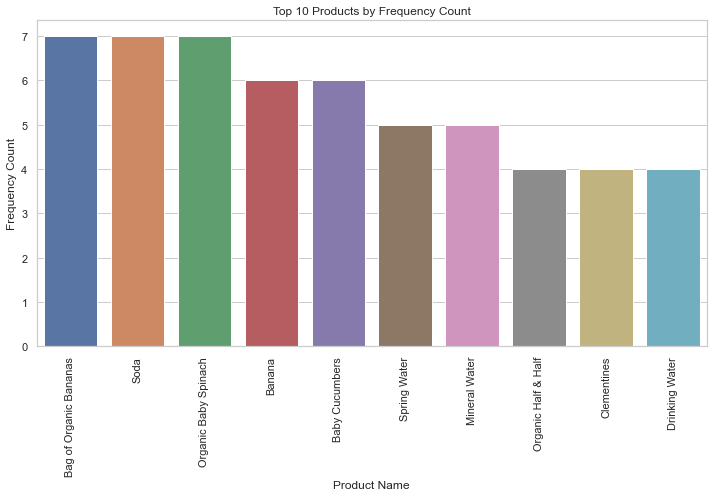

In [124]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_products, x='product_name', y='frequency')
plt.xticks(rotation=90)
plt.xlabel('Product Name')
plt.ylabel('Frequency Count')
plt.title('Top 10 Products by Frequency Count')
plt.show()

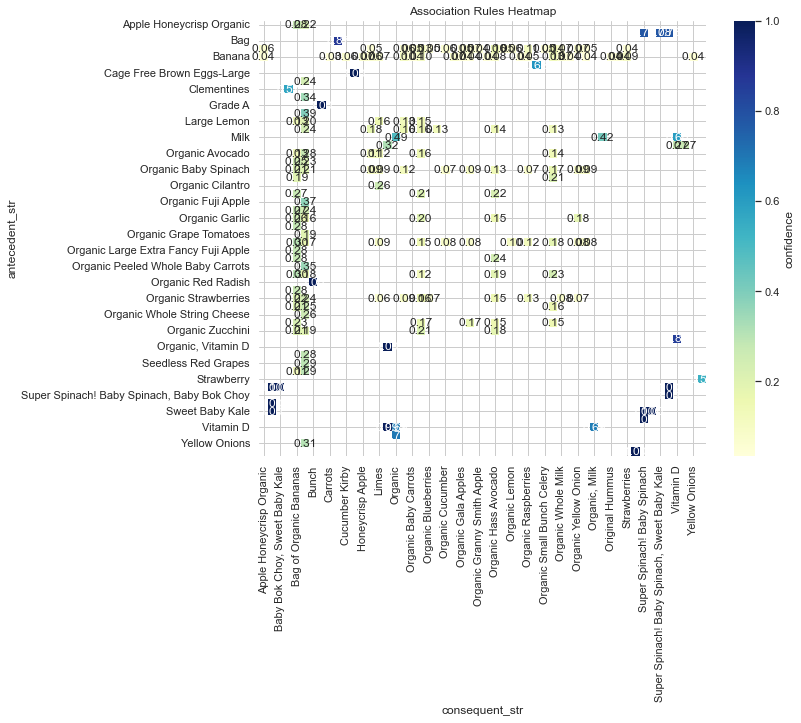

In [135]:
rules_df['antecedent_str'] = rules_df['antecedent'].apply(lambda x: ', '.join(map(str, x)))
rules_df['consequent_str'] = rules_df['consequent'].apply(lambda x: ', '.join(map(str, x)))

plt.figure(figsize=(10, 8))
heatmap_data = rules_df.pivot(index='antecedent_str', columns='consequent_str', values='confidence')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'confidence'})
plt.title('Association Rules Heatmap')
plt.show()

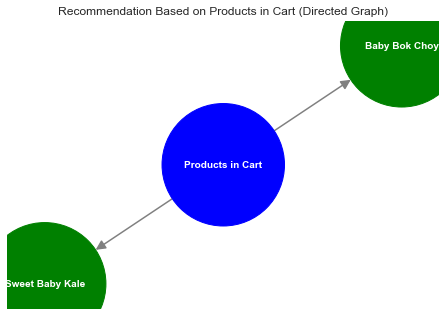

In [160]:
recommended = False

for subset in sorted_subsets:
    result = rules_df[rules_df['antecedent'].apply(lambda x: frozenset(x) == frozenset(subset))]
    if not result.empty:
        G = nx.DiGraph()
        G.add_node("Products in Cart", color='blue')
        G.add_nodes_from(recommended_products, color='green')

        for product in recommended_products:
            G.add_edge("Products in Cart", product)

        node_colors = [G.nodes[node]['color'] for node in G.nodes]

        pos = nx.spring_layout(G, seed=42)
        
        nx.draw(G, pos, with_labels=True, node_color=node_colors, font_color='white', font_size=10, node_size=15000, font_weight='bold', edge_color='gray', width=1.5, arrowsize=20)

        plt.title('Recommendation Based on Products in Cart (Directed Graph)')
        plt.show()

        recommended = True
        break

if not recommended:
    print(f"No Recommendation product found!")

### Item based collaborative filtering recommendations

In [50]:
order_details = pd.DataFrame(order_products_df)
order_details.head()

,order_id,product_name
0,1,"[Bulgarian Yogurt, Organic Hass Avocado, Org..."
1,2,"[Organic Egg Whites, Michigan Organic Kale, ..."
2,3,"[Organic Baby Spinach, Total 2% with Strawber..."
3,4,"[Plain Pre-Sliced Bagels, Kellogg's Nutri-Gra..."
4,5,"[Artichokes, Dairy Milk Fruit & Nut Chocolate..."


In [52]:
order_details['product_name'] = order_details['product_name'].apply(lambda products: [product.strip() for product in products])
order_details.head()

,order_id,product_name
0,1,"[Bulgarian Yogurt, Organic Hass Avocado, Organ..."
1,2,"[Organic Egg Whites, Michigan Organic Kale, Cl..."
2,3,"[Organic Baby Spinach, Total 2% with Strawberr..."
3,4,"[Plain Pre-Sliced Bagels, Kellogg's Nutri-Grai..."
4,5,"[Artichokes, Dairy Milk Fruit & Nut Chocolate ..."


In [53]:
mlb = MultiLabelBinarizer()
user_item_matrix = pd.DataFrame(mlb.fit_transform(order_details['product_name']), columns=mlb.classes_, index=order_details['order_id'])

In [54]:
user_item_matrix.head()

,,& Baby Wipes,& Cheese Biscuit,& Cheese Croissant,& Cheese Sandwiches,& Cheese Sauce,& Go! Hazelnut Spread + Pretzel Sticks,& Grape Ice Pops,& Peas,& Raisin,...,with Magnesium,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Orange Pulp!,with Pulp,with Spinach,with Tofu,with Whole Almonds,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
product_similarity = pd.DataFrame(cosine_similarity(user_item_matrix.T), index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [56]:
product_similarity.head()

,,& Baby Wipes,& Cheese Biscuit,& Cheese Croissant,& Cheese Sandwiches,& Cheese Sauce,& Go! Hazelnut Spread + Pretzel Sticks,& Grape Ice Pops,& Peas,& Raisin,...,with Magnesium,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Orange Pulp!,with Pulp,with Spinach,with Tofu,with Whole Almonds,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum
,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Baby Wipes,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Cheese Biscuit,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Cheese Croissant,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Cheese Sandwiches,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
product_similarity.columns

Index(['', '& Baby Wipes', '& Cheese Biscuit', '& Cheese Croissant',
       '& Cheese Sandwiches', '& Cheese Sauce',
       '& Go! Hazelnut Spread + Pretzel Sticks', '& Grape Ice Pops', '& Peas',
       '& Raisin',
       ...
       'with Magnesium', 'with Olive Oil Mayonnaise',
       'with Olive Oil Mayonnaise Dressing', 'with Orange Pulp!', 'with Pulp',
       'with Spinach', 'with Tofu', 'with Whole Almonds',
       'with Xylitol Cinnamon 18 Sticks Sugar Free Gum',
       'with Xylitol Minty Sweet Twist 18 Sticks Sugar Free Gum'],
      dtype='object', length=16804)

In [58]:
def item_based_collaborative_filtering_recommendations(product_name, similarity_matrix, user_item_matrix):
    all_recommendations = set()
    for product_name in products:
        similar_scores = similarity_matrix[product_name]
        similar_products = similar_scores.drop(product_name).sort_values(ascending=False)
        top_recommendations = similar_products.head(5).index.tolist()
        all_recommendations.update(top_recommendations)

    return list(all_recommendations)[:5]

In [61]:
products = ['Super Spinach! Baby Spinach', 'Sweet Baby Kale', 'Banana']
recommendations = item_based_collaborative_filtering_recommendations(products, product_similarity, user_item_matrix)
recommendations

['Honeycrisp Apple',
 'Baby Bok Choy',
 'Ready Wipe Flushable Wipes',
 'Strawberries',
 'Pumpkin & Spinach Stage 2 Baby Food']

### Order based collaborative filtering recommendations

In [82]:
def order_based_collaborative_filtering_recommendations(order_id, similarity_matrix, user_item_matrix):
    products_purchased = user_item_matrix.loc[order_id]
    products_to_predict = user_item_matrix.columns[products_purchased == 0]
    all_recommendations = set()
    for product_name in products_to_predict:
        similar_scores = similarity_matrix[product_name]
        similar_products = similar_scores.drop(product_name).sort_values(ascending=False)
        top_recommendations = similar_products.head(5).index.tolist()
        all_recommendations.update(top_recommendations)
    actual_purchased_products = products_purchased[products_purchased > 0].index.tolist()

    return actual_purchased_products, list(all_recommendations)[:5]

In [85]:
order_id = 5
actual_purchased_products, recommendations = order_based_collaborative_filtering_recommendations(order_id, product_similarity, user_item_matrix)
print(f'Items in order id : {actual_purchased_products}')
print(f'Recommendations based on order : {recommendations}')

Items in order id : ['2% Reduced Fat Milk', 'American Slices Cheese', 'Apricot Preserves', 'Artichokes', 'Bag of Organic Bananas', 'Bag of Organic Lemons', "Biscuits Orange Pim's", 'Boneless Skinless Chicken Breast Fillets', 'Chocolate', 'Clementines', 'Dairy Milk Fruit & Nut Chocolate Bar', 'Everyday  Facial Tissues', 'French Lavender Hand Wash', 'Fresh Fruit Salad', 'Just Crisp', 'Macaroni And Cheese', 'Matzos', 'Meyer Lemon', 'Mini & Mobile', 'Mini Original Babybel Cheese', 'Natural Artesian Water', 'One Ply Choose A Size Big Roll Paper Towel Rolls', 'Organic Hass Avocado', 'Organic Raspberries', 'Original Black Box Tablewater Cracker', 'Parmesan', 'Sensitive Toilet Paper', 'Spaghetti Pasta', 'Tea', 'Thin', 'Wafer']
Recommendations based on order : ['', 'Simply Clean Fragrance Free Wipes', 'No Sugar Added Muesli Cereal', 'Light & Fit Greek Crunch Coconut Chocolate Bliss', 'Activia Mixed Berry/Black Cherry Lowfat Yogurt']
